In [1]:
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from plot_shift.profit_based_thresholds_plot import (
    calculate_profit_thresholds,
    plot_profit_thresholds,
)
from ucimlrepo import fetch_ucirepo

from sklearn.calibration import calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [2]:
# Various variables used in the code
random_state = 42

In [3]:
# Load  processed dataset
bank_marketing = fetch_ucirepo(id=222)

X = bank_marketing.data.features 
y = bank_marketing.data.targets

In [4]:
X = X.drop(columns=["duration", "poutcome"])

In [5]:
X = X.drop(4)
y = y.drop(4)

In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.squeeze())  # Ensure y is 1D

In [7]:
# Transform features to prepare for modelling
transformer = ColumnTransformer(
    [
        (
            "categorical",
            OneHotEncoder(),
            [
                "job",
                "marital",
                "contact",
                "default",
                "housing",
                "education",
                "loan",
                "month",
                "education",
            ],
        ),
    ],
    remainder=StandardScaler(),
)
X = transformer.fit_transform(X)

In [8]:
smote = SMOTE(random_state=random_state)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"X shape: {X_resampled.shape}, y shape: {y_resampled.shape}")

X shape: (79842, 50), y shape: (79842,)


In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    random_state=random_state,
    test_size=0.2,  # 20% of the data for testing
)

In [10]:
classifier = RandomForestClassifier(random_state=random_state)
model_name = "Random Forest"

In [11]:
# Define dictionary to store results of each classifier
probabilities = {}
predictions = {}

# Prepare an array to store predictions for all training samples
y_prob = np.zeros(len(y_train))
y_pred = np.zeros(len(y_train))

# Fit the pipeline on the training fold
classifier.fit(X_train, y_train)

# Make and store probabilities and predictions for the test fold
y_prob = classifier.predict_proba(X_test)[:, 1]
y_pred = classifier.predict(X_test)

print("✅ Modelling completed.")

✅ Modelling completed.


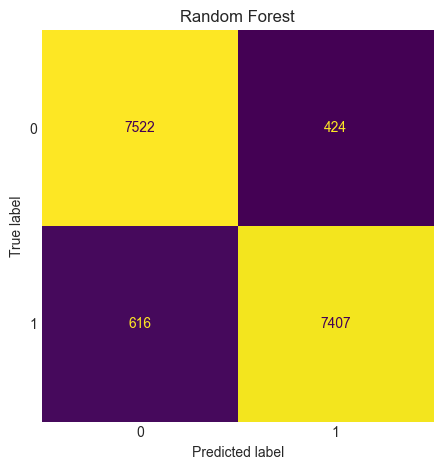

In [12]:
plt.style.use("seaborn-v0_8-dark")

_, ax = plt.subplots()

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    ax=ax,
    colorbar=False,
)
ax.set_title(model_name)

plt.tight_layout()
plt.show()

In [13]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      7946
           1       0.95      0.92      0.93      8023

    accuracy                           0.93     15969
   macro avg       0.94      0.93      0.93     15969
weighted avg       0.94      0.93      0.93     15969



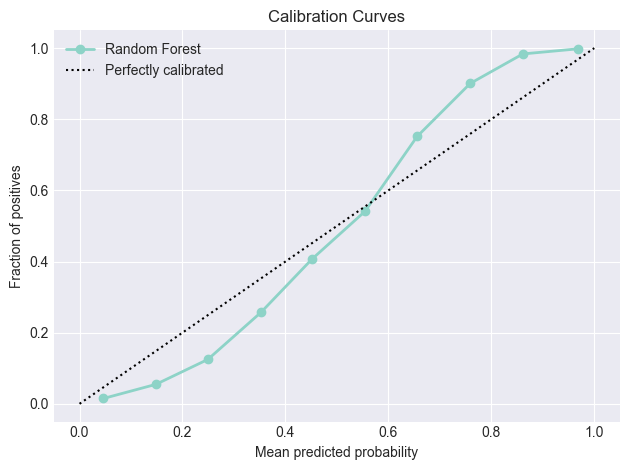

In [14]:
plt.style.use("seaborn-v0_8-darkgrid")

plt.figure()

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
plt.plot(prob_pred, prob_true, marker="o", label=model_name, linewidth=2)

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curves")
plt.legend()
plt.tight_layout()
plt.show()

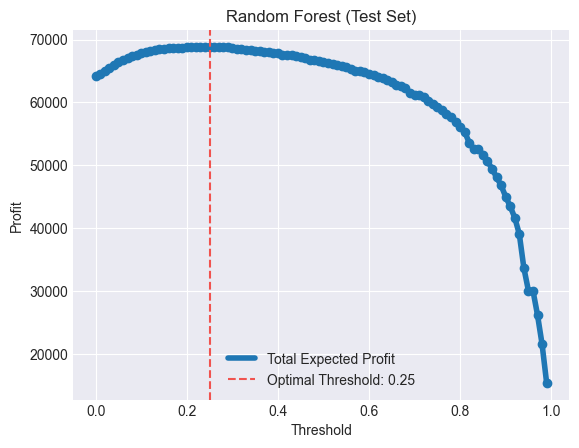

Maximum Profit 68,847
Optimal Threshold 0.250


In [16]:
(
    thresholds,
    profits,
    maximum_profit,
    optimal_threshold,
    precision,
    recall,
) = calculate_profit_thresholds(y_test, y_prob)

fig, ax = plt.subplots()
plot_profit_thresholds(
    profits,
    thresholds,
    optimal_threshold,
    ax=ax,
    model_name=f"{model_name} (Test Set)",
)
plt.show()

print("Maximum Profit", f"{maximum_profit:,}")
print("Optimal Threshold", f"{optimal_threshold:.3f}")